The goal of this notebook is to check the performance of various formulations

In [1]:
using Pkg; Pkg.activate()
using Serialization
using nGraph, Runner, Zoo
using JuMP, Interact, DataStructures

using Plots
gr()

┌ Info: Recompiling stale cache file /home/mark/.julia/compiled/v1.1/Runner/F5BZU.ji for Runner [4a6e9825-ed04-540b-82d3-f33d0e8d45fb]
└ @ Base loading.jl:1184


HTML{String}("<script>\n// Immediately-invoked-function-expression to avoid global variables.\n(function() {\n    var warning_div = document.getElementById(\"webio-warning-4544651667944134639\");\n    var hide = function () {\n        var script = document.getElementById(\"webio-setup-12532728510898449106\");\n        var parent = script && script.parentElement;\n        var grandparent = parent && parent.parentElement;\n        if (grandparent) {\n            grandparent.style.display = \"none\";\n        }\n        warning_div.style.display = \"none\";\n    };\n    if (typeof Jupyter !== \"undefined\") {\n        console.log(\"WebIO detected Jupyter notebook environment.\");\n        // Jupyter notebook.\n        var extensions = (\n            Jupyter\n            && Jupyter.notebook.config.data\n            && Jupyter.notebook.config.data.load_extensions\n        );\n        if (extensions && extensions[\"webio/main\"]) {\n            // Extension already loaded.\n            console.log(\"Jupyter WebIO nbextension detected; not loading ad-hoc.\");\n            hide();\n            return;\n        }\n        console.warn(\"Loading WebIO Jupyter extension on an ad-hoc basis. Consider enabling the WebIO nbextension for a stabler experience (this should happen automatically when building WebIO).\");\n        require([\"/assetserver/3cad0fc2e2ee49bd3b539296221dbaf141d25f44-dist/main.js\"], function (webIOModule) {\n            webIOModule.load_ipython_extension();\n        });\n        warning_div.innerHTML = \"<strong>Loading WebIO Jupyter extension on an ad-hoc basis. Consider enabling the WebIO nbextension for a stabler experience (this should happen automatically when building WebIO).</strong>\";\n    } else if (window.location.pathname.includes(\"/lab\")) {\n        // Guessing JupyterLa\n        console.log(\"Jupyter Lab detected; make sure the @webio/jupyter-lab-provider labextension is installed.\");\n        hide();\n        return;\n    }\n})();\n\n</script>\n<div\n    id=\"webio-warning-4544651667944134639\"\n    class=\"output_text output_stderr\"\n    style=\"padding: 1em; font-weight: bold;\"\n>\n    Unable to load WebIO. Please make sure WebIO works for your Jupyter client.\n    <!-- TODO: link to installation docs. -->\n</div>\n")

Plots.GRBackend()

In [2]:
function perf_plot(simple, synchronous; use_predicted = false, title = "")
    io_size = simple.io_sizes[]

    # Sanity check
    @assert io_size == synchronous.io_sizes[]

    # Show the IO size in GB
    @show io_size / 1E9

    total_dram = simple.default_alloc_size[] + io_size
    
    simple_runtimes = use_predicted ? simple.predicted_runtimes ./ 1E6 : simple.actual_runtimes
    synchronous_runtimes = use_predicted ? synchronous.predicted_runtimes ./ 1E6 : synchronous.actual_runtimes

    dram_performance = min(
        minimum(simple_runtimes),
        minimum(synchronous_runtimes),
    )

    plt = plot(
        (simple.dram_alloc_size .+ io_size) ./ total_dram,
        (simple_runtimes ./ dram_performance),
        marker = :square,
        label = use_predicted ? "Predicted Static ILP" : "Static ILP",
        minorgrid = true,
    )

    plot!(plt,
        (synchronous.dram_alloc_size .+ io_size) ./ total_dram,
        (synchronous_runtimes ./ dram_performance),
        marker = :o,
        label = use_predicted ? "Predicted Synchronous ILP" : "Synchronous ILP",
    )

    title!(plt, title)
    ylabel!(plt, "Relative Performance")
    xlabel!(plt, "Fraction of Total DRAM")

    return plt
end

perf_plot (generic function with 1 method)

io_size / 1.0e9 = 0.360044356


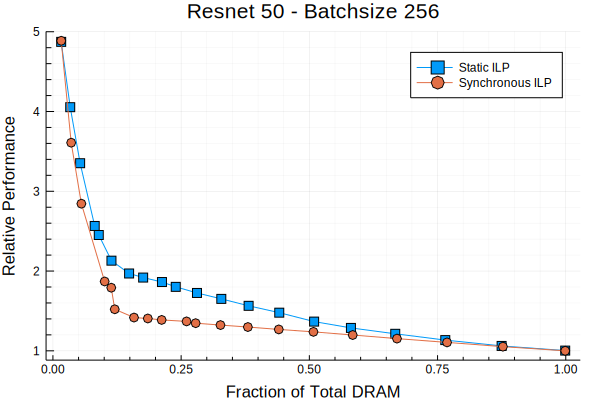

In [3]:
simple_data = deserialize("serials/simple_resnet50_256.jls")
synchronous_data = deserialize("serials/synchronous_resnet50_256.jls")
title = "Resnet 50 - Batchsize 256"

perf_plot(simple_data, synchronous_data; title = title)

io_size / 1.0e9 = 0.673961796


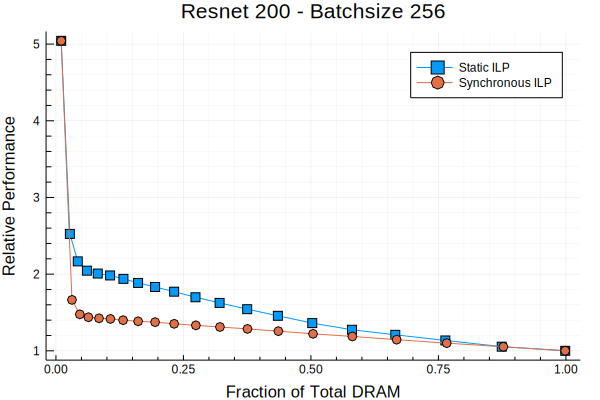

In [4]:
simple_data = deserialize("serials/simple_resnet200_256.jls")
synchronous_data = deserialize("serials/synchronous_resnet200_256.jls")
title = "Resnet 200 - Batchsize 256"

perf_plot(simple_data, synchronous_data; title = title)

io_size / 1.0e9 = 3.649152324


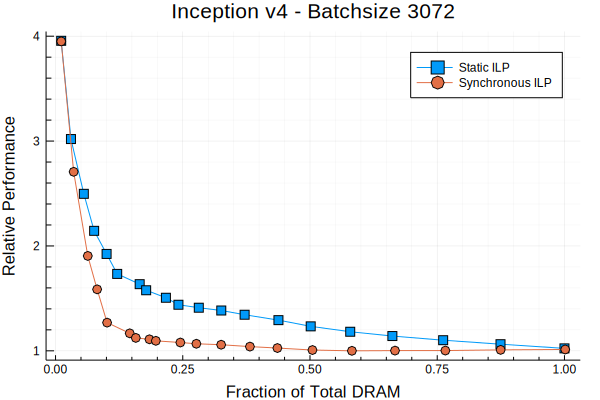

In [5]:
simple_data = deserialize("serials/simple_inception_v4_3072.jls")
synchronous_data = deserialize("serials/synchronous_inception_v4_3072.jls")
title = "Inception v4 - Batchsize 3072"

perf_plot(simple_data, synchronous_data; title = title)

io_size / 1.0e9 = 4.719318852


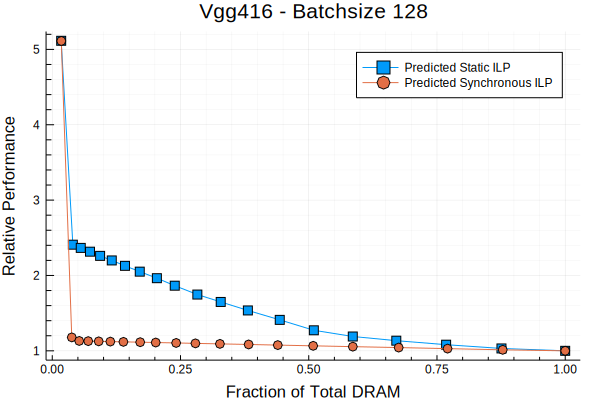

In [6]:
simple_data = deserialize("serials/skippedsimple_vgg416_128.jls")
synchronous_data = deserialize("serials/skippedsynchronous_vgg416_128.jls")
title = "Vgg416 - Batchsize 128"

perf_plot(simple_data, synchronous_data; use_predicted = true, title = title)

# Kernel Timings

In [ ]:
#f = () -> Zoo.inception_v4_training(3072)
#f = () -> Zoo.resnet_training(50, 256)
#f = () -> Zoo.vgg19_training(128)
f = () -> Zoo.inception_v4_training(128)

# Generator functions for the various optimization methods
simple(n) = function(data)
    bounds = Runner.allocation_bounds(data)
    x = round(Int, bounds.upper_bound * n / 1E6)
    return Runner.Simple(x)
end

synchronous(n) = function(data)
    bounds = Runner.allocation_bounds(data)
    x = round(Int, bounds.upper_bound * n / 1E6)
    println("Trying to use $x MB of memory")
    return Runner.Synchronous(x, 29000, 12000)
end

In [ ]:
#ratios = [0.0, 0.02, 0.05, 0.1, 0.2, 1.0]
ratios = [0.05]
exe_frame_pairs = map(ratios) do r
    fex, args, frame, metadata = Runner.factory(f, simple(r), Runner.OnlyIntermediate())
    return (fex = fex, frame = frame)
end

In [ ]:
# Do a marginal cost plot
pair = exe_frame_pairs[1]
fex = pair.fex
data = pair.frame.profile_data

@time marginals = Runner.Analyzer.marginal_costs(fex, data)
plot(marginals)

# Kernel Plots

In [ ]:
function genplot(kernels::Vector{Runner.Analyzer.Kernel}, filt)

    # Filter along each inner vector
    filtered_kernels = filter(
        x -> isequal(Runner.filter_out_io(x.params), Runner.filter_out_io(filt.params)), kernels)

    nrows = (kernels) -> 1
    ncols = (kernels) -> length(first(kernels).config)
    x = (kernels, row, col) -> [
        vcat(
            collect(prod.(k.params.input_sizes)),
            collect(prod.(k.params.output_sizes))
        )[col] for k in kernels
    ]
    y = (kernels, row, col) -> [k.index for k in kernels]
    color = (kernels, row, col) -> [k.config[col] == Runner.DRAM ? :blue : :red for k in kernels]
    title = function(kernels, row, col)
        k = first(kernels)
        if col <= length(k.params.input_formats)
            format = last(split(nGraph.Lib.get_mkldnn_string(k.params.input_formats[col]), ":"))
        else
            format = "is output"
        end
        return "$format"
    end

    KP = Runner.Analyzer.KernelPlot(filtered_kernels, nrows, ncols, x, y, color, title)
    plot(KP)
end

In [ ]:
executables = getproperty.(exe_frame_pairs, :fex)
kernels = Runner.Analyzer.kernel_breakdown.(executables)
unique_kernels = unique(x -> Runner.filter_out_io(x.params), first(kernels))

# Make options to select the kernel
options = OrderedDict("$i $(Runner.Analyzer.description(k))" => i for (i,k) in enumerate(unique_kernels))

mp = @manipulate for v in dropdown(options), ratio in ratios
    r = findfirst(isequal(ratio), ratios)
    genplot(kernels[r], unique_kernels[v])
end

## Reuse Distance

In [ ]:
md = @manipulate for ratio in ratios
    r = findfirst(isequal(ratio), ratios)
    
    # Unpack FluxExecutable and ProfileData
    pair = exe_frame_pairs[r]
    fex = pair.fex
    data = pair.frame.profile_data
    
    rd = Runner.Analyzer.reuse_distance(fex, data)
    plot(rd)
end